# Análisis de Datos del Titanic
Este notebook replica el flujo del notebook de Spotify aplicado al dataset `titanic.csv`.
Se enfatiza el análisis: cajas y bigotes, boxplots por categoría, correlaciones, scatter plots con línea de tendencia y mapas de calor.

Usaremos Pandas, Seaborn y Matplotlib. Después de cada visualización hay interpretación y conclusiones cortas.

# Análisis de Datos del Titanic
Notebook adaptado del estilo del profesor. Se incluyen visualizaciones y explicaciones interpretativas después de cada gráfico.

In [80]:
# Imports y configuración base
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
sns.set(style="whitegrid")
%matplotlib inline

## Introducción y notas


Este notebook realiza un análisis exploratorio del dataset Titanic (cajas y bigotes, correlaciones, scatterplots con línea de tendencia y mapa de calor) sin utilizar métodos de clustering. Después de cada visualización se incluyen interpretaciones breves.

In [81]:
data_path = Path('titanic.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
    print(f'Archivo cargado desde: {data_path}')
    display(df.head())
else:
    raise FileNotFoundError(f'No se encontró titanic.csv en: {data_path.resolve()}')

Archivo cargado desde: titanic.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [82]:
print('Columnas:', df.columns.tolist())
print('\nTipos:' )
display(df.dtypes)
print('\nValores nulos por columna:' )
display(df.isna().sum())

Columnas: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Tipos:


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Valores nulos por columna:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [83]:
df_clean = df.copy()
for col in ['Age','Fare','SibSp','Parch','Pclass','Survived']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
if 'Fare' in df_clean.columns:
    df_clean['Fare_pos'] = df_clean['Fare'].replace(0, np.nan)

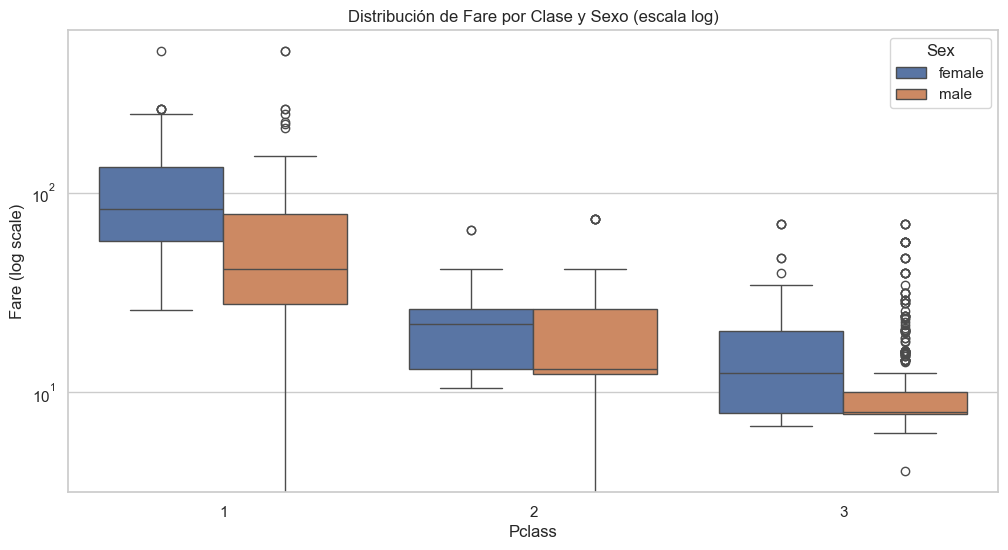

In [84]:
plt.figure(figsize=(12,6))
df_plot = df_clean.copy()
df_plot['Fare_plot'] = df_plot['Fare_pos'].fillna(df_plot['Fare'])
sns.boxplot(data=df_plot, x='Pclass', y='Fare_plot', hue='Sex')
plt.yscale('log')
plt.title('Distribución de Fare por Clase y Sexo (escala log)')
plt.ylabel('Fare (log scale)')
plt.show()

Interpretación:
- La variable `Fare` presenta outliers y mayor dispersión para la primera clase.
- Las comparaciones por sexo dentro de cada clase pueden revelar diferencias de acceso a tickets o combinaciones de reserva.

## Correlaciones y mapa de calor
Calcularemos la matriz de correlación entre variables numéricas y la visualizaremos mediante un heatmap.

In [85]:
num_cols = [c for c in ['Age','Fare','SibSp','Parch','Survived','Pclass'] if c in df_clean.columns]
corr = df_clean[num_cols].corr()
display(corr)

,Age,Fare,SibSp,Parch,Survived,Pclass
Age,1.000000,0.096067,-0.308247,-0.189119,-0.077221,-0.369226
Fare,0.096067,1.000000,0.159651,0.216225,0.257307,-0.549500
SibSp,-0.308247,0.159651,1.000000,0.414838,-0.035322,0.083081
Parch,-0.189119,0.216225,0.414838,1.000000,0.081629,0.018443
Survived,-0.077221,0.257307,-0.035322,0.081629,1.000000,-0.338481
Pclass,-0.369226,-0.549500,0.083081,0.018443,-0.338481,1.000000


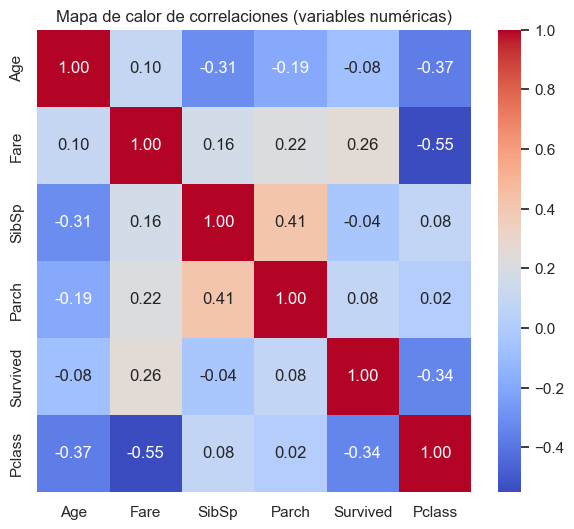

In [86]:
plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de calor de correlaciones (variables numéricas)')
plt.show()

Interpretación rápida:
- Observa correlaciones con `Survived` para identificar variables con asociación positiva o negativa.
- Recuerda la diferencia entre correlación y causalidad; controlar por `Pclass` y `Sex` en análisis posteriores.

## Scatter plots con línea de tendencia
Mostraremos pares interesantes (Age vs Fare, Fare vs Survived, SibSp vs Parch, Age vs Survived) y el coeficiente r de Pearson.

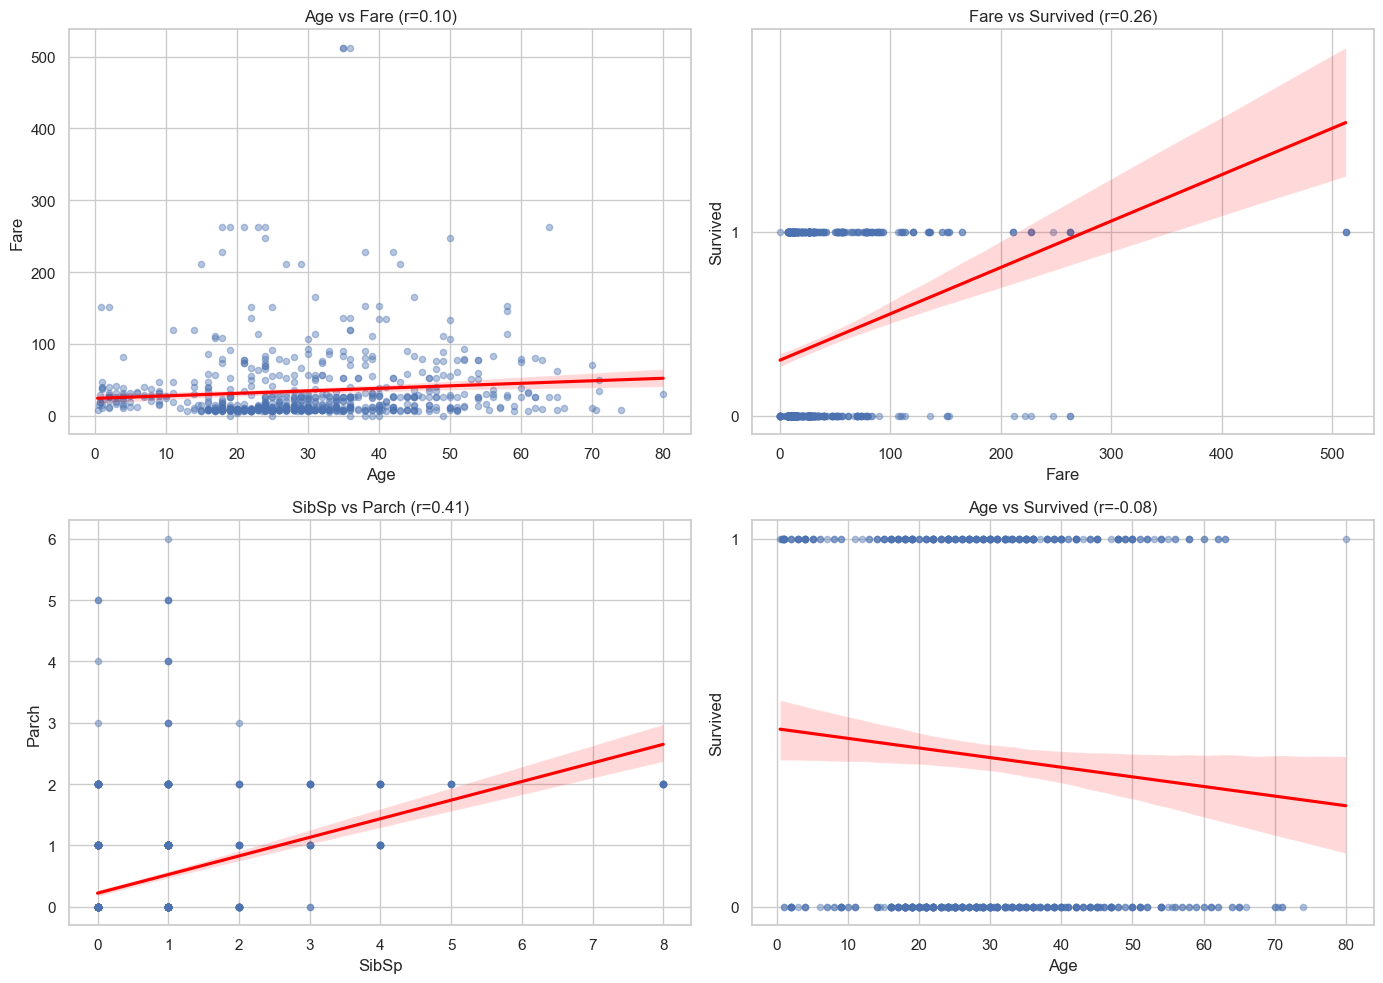

In [87]:
pairs = [('Age','Fare'), ('Fare','Survived'), ('SibSp','Parch'), ('Age','Survived')]
pairs = [p for p in pairs if p[0] in df_clean.columns and p[1] in df_clean.columns]
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()
for ax, (x,y) in zip(axes, pairs):
    sub = df_clean[[x,y]].dropna()
    if len(sub) < 2:
        ax.text(0.5,0.5,'Datos insuficientes', ha='center')
        ax.set_axis_off()
        continue
    r = sub[x].corr(sub[y])
    sns.regplot(data=sub, x=x, y=y, ax=ax, scatter_kws={'alpha':0.4,'s':20}, line_kws={'color':'red'})
    ax.set_title(f'{x} vs {y} (r={r:.2f})')
    if x == 'Survived' or y == 'Survived':
        ax.set_yticks([0,1])
plt.tight_layout()
plt.show()

Interpretación:
- `Fare` vs `Survived`: r positiva suele indicar que tarifas mayores se asociaron con mayor supervivencia (efecto de clase).
- `Age` vs `Survived`: revisar estratos por `Pclass` y `Sex` para entender mejor el patrón.

In [88]:
pairs = []
cols = corr.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        a, b = cols[i], cols[j]
        pairs.append((a, b, corr.loc[a,b]))
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
print('Top 5 pares por |r|:')
for a,b,r in pairs_sorted[:5]:
    signo = 'positiva' if r>0 else 'negativa'
    print(f' - {a} vs {b}: r={r:.2f} ({signo})')

# 5 oraciones interpretativas
if pairs_sorted:
    top = pairs_sorted[0]
    print('Cinco oraciones interpretativas:')
    print(f"1) El par con mayor correlación absoluta es {top[0]} vs {top[1]} (r={top[2]:.2f}), indicando una asociación {'positiva' if top[2]>0 else 'negativa' }.")
    influence = {v: sum(abs(corr[v].drop(v))) for v in cols}
    var_most = max(influence.items(), key=lambda x: x[1])
    var_least = min(influence.items(), key=lambda x: x[1])
    print(f"2) La variable más influyente (suma de |r|) es {var_most[0]} con suma={var_most[1]:.2f}.")
    print(f"3) La variable menos correlacionada es {var_least[0]} con suma={var_least[1]:.2f}.")
    if 'Survived' in cols:
        print(f"4) Correlaciones con 'Survived': {[ (c, float(corr.loc['Survived', c])) for c in cols if c!='Survived' ]}")
    print('5) Recordar que correlación no implica causalidad; controlar por Pclass y Sex en análisis posteriores.')

Top 5 pares por |r|:
 - Fare vs Pclass: r=-0.55 (negativa)
 - SibSp vs Parch: r=0.41 (positiva)
 - Age vs Pclass: r=-0.37 (negativa)
 - Survived vs Pclass: r=-0.34 (negativa)
 - Age vs SibSp: r=-0.31 (negativa)
Cinco oraciones interpretativas:
1) El par con mayor correlación absoluta es Fare vs Pclass (r=-0.55), indicando una asociación negativa.
2) La variable más influyente (suma de |r|) es Pclass con suma=1.36.
3) La variable menos correlacionada es Survived con suma=0.79.
4) Correlaciones con 'Survived': [('Age', -0.07722109457217757), ('Fare', 0.25730652238496265), ('SibSp', -0.03532249888573559), ('Parch', 0.08162940708348335), ('Pclass', -0.3384810359610151)]
5) Recordar que correlación no implica causalidad; controlar por Pclass y Sex en análisis posteriores.


## Conclusiones Finales

Se observaron claras diferencias entre las clases (Pclass). La primera clase tiene tarifas más altas y mayores tasas de supervivencia.
La tarifa (Fare) parece relacionarse con la supervivencia, aunque probablemente está influenciada por la clase social.
La edad también varía según la clase y el sexo, y los niños en general tuvieron mejores tasas de supervivencia.

# Hallazgos Principales
Pclass es una de las variables más importantes, ya que afecta tanto el precio del boleto como la probabilidad de sobrevivir.
Fare refleja el nivel socioeconómico y se asocia con la supervivencia, pero no necesariamente de forma directa.
Variables como Age, SibSp y Parch aportan información útil sobre los grupos familiares y deberían considerarse en futuros modelos.

# Limitaciones
Hay datos faltantes, sobre todo en Age y Cabin, que podrían afectar los resultados si no se manejan bien.
Las correlaciones no implican causalidad; algunas relaciones pueden deberse a factores no considerados.
Existen outliers en Fare que conviene analizar antes de seguir con el modelado.

# Conclusión
En general, las variables más relevantes son Pclass, Fare y Age.
Con una imputación correcta y un análisis más detallado, se pueden construir modelos predictivos más confiables y con mejores resultados.

## Respuestas a las preguntas del análisis


### 1) ¿Hay alguna variable que no aporta información?


- `PassengerId`, `Name`, `Ticket`: son identificadores/etiquetas con alta cardinalidad; no aportan señal directa para el análisis explicativo.


- `Cabin`: tiene muchos valores faltantes; en bruto aporta poco y puede introducir sesgo si no se trata.


- `Fare_pos`: fue creada solo para facilitar gráficos (evitar ceros); no debe usarse como variable de análisis por separado (usar `Fare`).


- `Survived`: es la variable objetivo; no debe usarse como variable explicativa en análisis correlacionales con otras features sin tener esto en cuenta.




### 2) Si tuvieras que eliminar variables, ¿cuáles quitarías y por qué?


- `PassengerId`, `Name`, `Ticket`: no aportan patrón numérico interpretable y pueden complicar el análisis.


- `Cabin`: eliminar en una primera versión por alta proporción de nulos; alternativamente, transformarla (p. ej. extraer la letra de cubierta) si se busca aprovecharla.


- No usar `Fare_pos` (solo para visualización) y mantener `Fare` con transformaciones (log) cuando sea necesario.


- Considerar combinar `SibSp` y `Parch` en `FamilySize` (= SibSp + Parch + 1) para reducir redundancia; si se crea, evaluar retirar uno de los dos originales.




### 3) ¿Existen variables que tengan datos extraños?


- `Age`: faltantes; pueden existir edades muy pequeñas (bebés) que son válidas pero requieren imputación/estratificación.


- `Fare`: presenta outliers (tarifas muy altas) y ceros; conviene visualizar en log y considerar winsorización/tratamiento de valores extremos.


- `Cabin`: gran cantidad de nulos; usarla sin ingeniería puede distorsionar.




### 4) Si comparas las variables, ¿todas están en rangos similares? ¿Crees que esto afecte?


- No. `Fare` puede ir de 0 a >500, `Age` ~0–80, `Pclass` ∈ {1,2,3}, `SibSp`/`Parch` suelen ser pequeños.


- Estas diferencias de escala afectan comparaciones y algunos métodos (especialmente basados en distancia). Para las visualizaciones se usó escala log para `Fare` y, en modelos, es recomendable estandarizar/normalizar según corresponda.




### 5) ¿Puedes encontrar grupos que se parezcan? ¿Qué grupos son estos? (sin clustering)


- Usando variables categóricas y cortes naturales se observan grupos claros:


  - Por `Pclass`: 1ª clase (tarifas altas, mayor supervivencia), 2ª clase (valores intermedios), 3ª clase (tarifas bajas, menor supervivencia).


  - Por `Sex`: diferencias marcadas en supervivencia entre mujeres y hombres.


  - Por `Fare` (cuartiles): pasajeros de tarifa alta vs. baja muestran comportamientos distintos, en parte por su relación con `Pclass`.


  - Por `Age` (niños/adultos/mayores): los niños tienden a tener mejores tasas de supervivencia.


- Estos grupos emergen de las propias categorías y cortes del EDA, sin necesidad de clustering.




### 6) Conclusión (gráficas y correlaciones)


- `Pclass` y `Fare` están fuertemente asociados entre sí y con `Survived`: tarifas más altas (1ª clase) suelen corresponder a mayor supervivencia.


- `SibSp` y `Parch` se correlacionan positivamente (viaje en familia); tamaños familiares grandes pueden asociarse con menor supervivencia promedio.


- `Age` muestra patrones por estratos (sexo y clase); los niños presentan tasas de supervivencia superiores en general.


- Las correlaciones no implican causalidad; `Pclass` y `Sex` actúan como factores de confusión relevantes.


- Para mejorar el análisis/modelado: imputar `Age` por estratos (`Pclass`×`Sex`), transformar `Fare` (log), crear `FamilySize`/`IsAlone` y codificar adecuadamente `Sex`/`Embarked`.




En síntesis: las variables más influyentes siguen siendo `Pclass`, `Fare` y `Sex` (si se incluye); `Age` aporta al segmentar por grupos. Las visualizaciones y la matriz de correlación respaldan patrones socioeconómicos y familiares en la supervivencia, sin usar técnicas de clustering.